<img src='http://dankilde.tripod.com/webonmediacontents/crimestats.jpg?1409168946245' height=480 width=550/>

When it comes to the issue of crime, one of the questions we'd like to answer is what factors have a relationship with crime. In this analysis, I'll be looking at data for the counties of New York State for the year of 2016. The article <a href='https://www2.fbi.gov/ucr/cius2009/about/variables_affecting_crime.html'>Variables Affecting Crime</a> will serve as the guide to what variables I will choose initially for the analysis. These are the steps I'll be taking:

1. Collect the data from various sources.
2. Clean the data.
3. Explore the data to try to identify variables that are likely to have a relationship with Total Crime Rate.
4. Finally, perform an OLS multiple regression on our identified variables.

<i>
NOTE: 
   1. The last U.S. census was performed in 2010, therefore, some variables are merely estimates from the source for the year 2016.
   2. A few of the variables are from 2015 and have no 2016 update as of the completion of this notebook. I'm making the assumption that the true values for the year of 2016 on that variable are not substantially different from the year prior. 
</i>

<font size='1'>Source of Image: http://dankilde.tripod.com/webonmediacontents/crimestats.jpg?1409168946245</font> 

<h2>Gather and Clean the Data</h2>
***

<h3>We will be looking at data from five sources for our analysis.</h3>

1. Census statistics taken from the <a href='https://www.census.gov/quickfacts/geo/dashboard/yatescountynewyork/PST045216'>U.S. Census Bureau.</a>
2. Unemployment rates taken from <a href='https://www.bls.gov/lau/#cntyaa'>Bureau of Labor Statistics</a>
3. High School Drop Outrates taken from <a href='https://data.nysed.gov/downloads.php'>New York State Education Department</a>
4. Crime rates taken from <a href='http://www.criminaljustice.ny.gov/crimnet/ojsa/countycrimestats.htm'>Division of Criminal Justics Services, New York State</a>
5. Divorce rates taken from <a href='https://www.health.ny.gov/statistics/vital_statistics/2015/table51.htm'>New York State Department of Health</a>

<i>NOTE: The links take you directly to the website where the data can be found. I've provided that data in their original form as well as the final cleaned version <a href='#'>here.</a></i>

In [1]:
# Import the libraries we'll be using
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr
from statsmodels.formula.api import ols

%matplotlib inline

<h3 style='color: gray'>1a. Census</h3>
***
<p>I had to retrieve the data six counties at the time per the limit they had on their website. This resulted in 11
csv files that I concatenated as shown below.</p>

In [2]:
# Get a list of all the datasets
census_datasets = []
census_datasets.append(pd.read_csv('../data/crime-notebook-data/2016-ny-census-data/QuickFacts Sep-06-2017.csv'))
for i in range(1,11):
    census_datasets.append(pd.read_csv('../data/crime-notebook-data/2016-ny-census-data/QuickFacts Sep-06-2017({0}).csv'.format(i)))

# Concatenate them into one DataFrame named 'census'
census = census_datasets[0]
for dataframe in census_datasets[1:]:
    census = pd.concat([census,dataframe.ix[:,2:]],axis=1)

census.head(3)

,Fact,Fact Note,"Cayuga County, New York","Value Note for Cayuga County, New York","Cattaraugus County, New York","Value Note for Cattaraugus County, New York","Broome County, New York","Value Note for Broome County, New York","Bronx County (Bronx Borough), New York","Value Note for Bronx County (Bronx Borough), New York",...,"Warren County, New York","Value Note for Warren County, New York","Ulster County, New York","Value Note for Ulster County, New York","Tompkins County, New York","Value Note for Tompkins County, New York","Yates County, New York","Value Note for Yates County, New York","Wyoming County, New York","Value Note for Wyoming County, New York"
0,"Population estimates, July 1, 2016, (V2016)",NaN,"77,861",NaN,"77,677",NaN,"195,334",NaN,"1,455,720",NaN,...,"64,567",NaN,"179,225",NaN,"104,871",NaN,"24,923",NaN,"40,791",NaN
1,"Population estimates base, April 1, 2010, (V2...",NaN,"80,003",NaN,"80,343",NaN,"200,689",NaN,"1,385,107",NaN,...,"65,700",NaN,"182,512",NaN,"101,594",NaN,"25,351",NaN,"42,162",NaN
2,"Population, percent change - April 1, 2010 (es...",NaN,-2.7%,NaN,-3.3%,NaN,-2.7%,NaN,5.1%,NaN,...,-1.7%,NaN,-1.8%,NaN,3.2%,NaN,-1.7%,NaN,-3.3%,NaN


In [3]:
# Many of the columns that start with 'Value Note' seem to be have a lot of NaN values.

# Show's the first five columns where all values are NaN
print(census.columns[census.isnull().all()][:5])

# In fact, all columns that start with 'Value Note' are filled entirely with NaN so we can easily drop them as they 
# don't give us any information. 'Fact Note' is mostly NaN as well so we'll drop that tboo. 
census.dropna(axis=1,how='all',inplace=True)
census.drop('Fact Note', axis=1,inplace=True)

Index(['Value Note for Cayuga County, New York',
       'Value Note for Cattaraugus County, New York',
       'Value Note for Broome County, New York',
       'Value Note for Bronx County (Bronx Borough), New York',
       'Value Note for Allegany County, New York'],
      dtype='object')


In [4]:
# If we look at the last few rows we also see that they are mostly filled with NaN's so we'll drop those too
census.tail(3)

# Drops any rows with less than 5 non-NaN values. I'll drop the row 'FIPS Code' here because we'll be using county
# names instead
census.dropna(thresh=5,inplace=True)

FIPS_index = census[census['Fact'] == 'FIPS Code'].index
census.drop(FIPS_index,inplace=True)

# Because we are going to merging data from multiple datasets we want to use the names of the counties as the index to 
# merge on. Therefore, we're going to rename them so that they're easier to match with.
import re

# Function to pull out only the County name
def get_county_name_census(name):
    if name == 'New York County (Manhattan Borough), New York':
        return 'New York'
    elif name == 'St. Lawrence County, New York':
        return 'St. Lawrence'
    else:
        return re.split(', | ',name)[0]

col_names = list(map(get_county_name_census,census.columns[1:]))
col_names.insert(0, 'Fact')
census.columns = col_names
census.columns

Index(['Fact', 'Cayuga', 'Cattaraugus', 'Broome', 'Bronx', 'Allegany',
       'Albany', 'Cortland', 'Columbia', 'Clinton', 'Chenango', 'Chemung',
       'Chautauqua', 'Fulton', 'Franklin', 'Essex', 'Erie', 'Dutchess',
       'Delaware', 'Kings', 'Jefferson', 'Herkimer', 'Hamilton', 'Greene',
       'Genesee', 'Nassau', 'Montgomery', 'Monroe', 'Madison', 'Livingston',
       'Lewis', 'Orange', 'Ontario', 'Onondaga', 'Oneida', 'Niagara',
       'New York', 'Rensselaer', 'Queens', 'Putnam', 'Otsego', 'Oswego',
       'Orleans', 'Schuyler', 'Schoharie', 'Schenectady', 'Saratoga',
       'Rockland', 'Richmond', 'Tioga', 'Steuben', 'Sullivan', 'Suffolk',
       'St. Lawrence', 'Seneca', 'Westchester', 'Wayne', 'Washington',
       'Warren', 'Ulster', 'Tompkins', 'Yates', 'Wyoming'],
      dtype='object')

In [5]:
# Next, we want to transpose the dataframe so that we can perform our analyis on it more appropriately. We can do this
# by setting 'Fact' as the index and then using 'T' on the dataframe to transpose it
census.set_index('Fact',inplace=True)
census = census.T

census.head()

Fact,"Population estimates, July 1, 2016, (V2016)","Population estimates base, April 1, 2010, (V2016)","Population, percent change - April 1, 2010 (estimates base) to July 1, 2016, (V2016)","Population, Census, April 1, 2010","Persons under 5 years, percent, July 1, 2016, (V2016)","Persons under 5 years, percent, April 1, 2010","Persons under 18 years, percent, July 1, 2016, (V2016)","Persons under 18 years, percent, April 1, 2010","Persons 65 years and over, percent, July 1, 2016, (V2016)","Persons 65 years and over, percent, April 1, 2010",...,"Total nonemployer establishments, 2015","All firms, 2012","Men-owned firms, 2012","Women-owned firms, 2012","Minority-owned firms, 2012","Nonminority-owned firms, 2012","Veteran-owned firms, 2012","Nonveteran-owned firms, 2012","Population per square mile, 2010","Land area in square miles, 2010"
Cayuga,"77,861","80,003",-2.7%,"80,026",5.0%,5.3%,20.2%,21.6%,17.7%,15.3%,...,"4,243","4,971","3,040","1,511",188,"4,563",439,"4,210",115.7,691.58
Cattaraugus,"77,677","80,343",-3.3%,"80,317",5.8%,6.3%,22.7%,23.4%,17.9%,15.5%,...,"3,831","5,322","3,084","1,554",279,"4,792",526,"4,496",61.4,"1,308.35"
Broome,"195,334","200,689",-2.7%,"200,600",5.3%,5.2%,19.6%,20.2%,18.3%,16.4%,...,"10,019","13,671","7,929","4,461","1,271","11,856","1,285","11,561",284.2,705.77
Bronx,"1,455,720","1,385,107",5.1%,"1,385,108",7.3%,7.4%,25.3%,26.6%,11.7%,10.5%,...,"114,788","135,782","61,813","68,705","110,222","23,478","7,987","125,616","32,903.6",42.10
Allegany,"47,077","48,919",-3.8%,"48,946",5.1%,5.4%,20.4%,21.6%,17.7%,15.2%,...,"2,451","2,710","1,454",920,185,"2,427",244,"2,298",47.6,"1,029.31"


In [6]:
# Currently all our values our strings. We want to remove all the unnecessary characters 

# Removes ',' '$' and '%
def clean_value(val):
    chars = ['$',',','%']
    for c in chars:
        if c in val:
            val = val.replace(c,'')
    return val

for col in census.columns:
    census[col] = census[col].apply(clean_value)

In [7]:
# For some odd reason the letter 'Z' is in place for the value of the percent change in population from 2010 to 2016 
# for the county of Suffolk, so we're going to change that to represent the right number.
old_value = census.ix['Suffolk']['Population, percent change - April 1, 2010 (estimates base) to July 1, 2016,  (V2016)']

# This code merely represents (Total Population in 2016 - Total Population in 2010) / Total Population in 2010 for the
# county of Suffolk
suffolk = census.ix['Suffolk']
census.ix['Suffolk','Population, percent change - April 1, 2010 (estimates base) to July 1, 2016,  (V2016)'] = (
    float(suffolk['Population estimates, July 1, 2016,  (V2016)']) - (
        float(suffolk['Population estimates base, April 1, 2010,  (V2016)'])
)) / float(suffolk['Population estimates base, April 1, 2010,  (V2016)']) * 100

new_value = census.ix['Suffolk']['Population, percent change - April 1, 2010 (estimates base) to July 1, 2016,  (V2016)']

print('Old Value: {0}, New Value: {1}'.format(old_value,new_value))

Old Value: Z, New Value: -0.04132065362978837


In [8]:
# Our last step with this dataset is to select the variables(features) we think have a relationship with 
# the crime rate. I've selected the ones I believe I have a relationship. You're more than welcome to use the other
# variables as you see fit

final_cols = ['Population, percent change - April 1, 2010 (estimates base) to July 1, 2016,  (V2016)',
               'Owner-occupied housing unit rate, 2011-2015',
               'Persons per household, 2011-2015',
               'High school graduate or higher, percent of persons age 25 years+, 2011-2015',
               'Bachelor\'s degree or higher, percent of persons age 25 years+, 2011-2015',
               'Persons  without health insurance, under age 65 years, percent',
               'In civilian labor force, total, percent of population age 16 years+, 2011-2015',
               'Median household income (in 2015 dollars), 2011-2015',
               'Persons in poverty, percent',
               'Population estimates, July 1, 2016,  (V2016)',
               'Land area in square miles, 2010']

census = census[final_cols]

# Now let's convert all the values to floats so we can perform calculations on them later
census = census.astype(float)

# We'll also create another column for Population Density(per sq. mile) because it's not already in the dataset but we have all
# information we need to calculate it
census['Population Density(sq.m)'] = census['Population estimates, July 1, 2016,  (V2016)'] / census['Land area in square miles, 2010']

# Drop the last two columns.
census.drop(['Population estimates, July 1, 2016,  (V2016)','Land area in square miles, 2010'],axis=1,inplace=True)

# Lastly for this dataset, we'll rename the column names to be a little more concise
new_col_names = ['Pop.Pct.Change 2010-16', 'Owner Occupy House Rate, 2011-2015','Persons per household',
           'High School grad or Higher, 2011-2015','Bachelor\'s Degree or Higher, 2011-2015',
           'Persons w/out health insurance, under 65 pct', 'Civilian Labor Force Partcipation Pct', 
           'Median Household income', 'Poverty Pct.', 'Population Density(sq.m)']
census.columns = new_col_names

census.reset_index(inplace=True)
census.rename(index=str,columns={'index':'County'},inplace=True)

census.head()

,County,Pop.Pct.Change 2010-16,"Owner Occupy House Rate, 2011-2015",Persons per household,"High School grad or Higher, 2011-2015","Bachelor's Degree or Higher, 2011-2015","Persons w/out health insurance, under 65 pct",Civilian Labor Force Partcipation Pct,Median Household income,Poverty Pct.,Population Density(sq.m)
0,Cayuga,-2.7,71.1,2.43,87.7,21.4,6.7,61.4,52082.0,12.7,112.584227
1,Cattaraugus,-3.3,71.3,2.41,87.9,17.8,7.5,59.2,42601.0,18.0,59.370199
2,Broome,-2.7,65.7,2.37,89.9,27.2,6.4,58.7,46261.0,17.7,276.767219
3,Bronx,5.1,19.0,2.86,70.6,18.9,11.1,59.5,34299.0,30.3,34577.672209
4,Allegany,-3.8,73.1,2.36,88.6,20.0,6.2,57.0,42776.0,16.8,45.736464


<h3 style='color: gray'>1b. Unemployment</h3>
***

In [9]:
unemployment = pd.read_excel('../data/crime-notebook-data/laucnty16.xlsx',sheetname='laucnty16',skiprows=np.arange(4))

# Select columns we're interested in and drop the first(all NaN) row 
unemployment = unemployment[['County Name/State Abbreviation','(%)']]
unemployment.columns = ['County','Unemployment Rate']
unemployment.drop(0)

# The data includes all counties in the U.S. so we're going to extract only those counties in New York
idx1 = unemployment.index[(unemployment['County'] == 'Albany County, NY')]
idx2 = unemployment.index[(unemployment['County'] == 'Yates County, NY')]
unemployment = unemployment.ix[idx1[0]:idx2[0]]

# Function to pull out only the County Name
def get_county_name_unemployment(name):
    if name == 'New York County, NY':
        return 'New York'
    elif name == 'St. Lawrence County, NY':
        return 'St. Lawrence'
    else:
        return name.split(' ')[0]
        
unemployment['County'] = unemployment['County'].apply(get_county_name_unemployment)

# unemployment.set_index('County',inplace=True)
unemployment.head()


,County,Unemployment Rate
1828,Albany,4.0
1829,Allegany,6.2
1830,Bronx,7.1
1831,Broome,5.4
1832,Cattaraugus,5.9


<h3 style='color: gray'>1c. High School Dropout</h3>
***

In [10]:
dropout = pd.read_csv('../data/crime-notebook-data/GRAD_RATE_AND_OUTCOMES_2016.csv')

# First, we want to only use the rows that are county aggregated and represent all students
dropout = dropout[(dropout['AGGREGATION_TYPE'] == 'County') & (dropout['SUBGROUP_NAME'] == 'All Students')]

dropout.head()

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,REPORT_SCHOOL_YEAR,AGGREGATION_INDEX,AGGREGATION_TYPE,AGGREGATION_CODE,AGGREGATION_NAME,ENTITY_INACTIVE_DATE,LEA_BEDS,LEA_NAME,NRC_CODE,NRC_DESC,...,REG_ADV_CNT,REG_ADV_PCT,NON_DIPLOMA_CREDENTIAL_CNT,NON_DIPLOMA_CREDENTIAL_PCT,STILL_ENR_CNT,STILL_ENR_PCT,GED_CNT,GED_PCT,DROPOUT_CNT,DROPOUT_PCT
537,2015-16,2,County,10000000000,County: ALBANY,NaN,NaN,NaN,NaN,NaN,...,1257,40%,35,1%,80,3%,11,0%,333,11%
554,2015-16,2,County,10000000000,County: ALBANY,NaN,NaN,NaN,NaN,NaN,...,1241,40%,45,1%,100,3%,7,0%,284,9%
571,2015-16,2,County,10000000000,County: ALBANY,NaN,NaN,NaN,NaN,NaN,...,1245,39%,36,1%,278,9%,4,0%,265,8%
588,2015-16,2,County,10000000000,County: ALBANY,NaN,NaN,NaN,NaN,NaN,...,1245,39%,36,1%,242,8%,4,0%,265,8%
605,2015-16,2,County,20000000000,County: ALLEGANY,NaN,NaN,NaN,NaN,NaN,...,165,30%,12,2%,14,3%,4,1%,37,7%


In [11]:
# Now we want to replace '-' with NaN and convert the column types to int
for col in ['ENROLL_CNT', 'DROPOUT_CNT']:
    dropout[col].replace('-',np.NaN,inplace=True)
    dropout[col] = dropout[col].astype(int)

# Each county has 4 types on cohorts graduating based on when a student started highschool. Therefore, we want to sum
# the counts for the cohorts to get the total count for the county
dropout = dropout.groupby('COUNTY_NAME')[['ENROLL_CNT', 'DROPOUT_CNT']].sum()

# Create a column for the dropout rate
dropout['DROPOUT_PCT'] = dropout['DROPOUT_CNT'] / dropout['ENROLL_CNT'] * 100

dropout.reset_index(inplace=True)
dropout.rename(index=str,columns={'COUNTY_NAME':'County'},inplace=True)

dropout.drop(['ENROLL_CNT','DROPOUT_CNT'],axis=1,inplace=True)

# Function to pull out only the county name
def get_county_name_dropout(name):
    if name == 'NEW YORK':
        return 'New York'
    elif name == 'SAINT LAWRENCE':
        return 'St. Lawrence'
    else:
        return name[0] + name[1:].lower()
    
dropout['County'] = dropout['County'].apply(get_county_name_dropout)

dropout.head()

,County,DROPOUT_PCT
0,Albany,9.047882
1,Allegany,5.210238
2,Bronx,15.895440
3,Broome,8.840776
4,Cattaraugus,9.561849


<h3 style='color: gray'>1d. Divorce</h3>
***

In [12]:
# Get Divorce totals by County for 2015
divorce_total = pd.read_html('https://www.health.ny.gov/statistics/vital_statistics/2015/table51.htm')
divorce_total = divorce_total[0]

# Get Population Estimated Counts for 2015
population_2015 = pd.read_html('https://www.health.ny.gov/statistics/vital_statistics/2015/table02.htm')
population_2015 = population_2015[0]

# Combine the data using County as the key
divorce = pd.merge(divorce_total, population_2015,on='County')

#Drop Non-County rows
divorce.drop([0,1,2,3,4,5,6,7,13,14,15,16],inplace=True)

# The 'crude divorce rate' is typically the number of divorces per 1000 people
divorce['DivorceRate'] = (divorce['Total'] * 1000) / divorce['2015 Population Estimate ']
divorce = divorce[['County','DivorceRate']]

#Find index of row 'St Lawrence' and change it to 'St. Lawrence'
idx = divorce.index[divorce['County'] == 'St Lawrence']
divorce.set_value(index=idx[0],col='County',value='St. Lawrence')

divorce.head()

,County,DivorceRate
8,Bronx,3.680664
9,Kings,1.407802
10,New York,6.306407
11,Queens,2.505611
12,Richmond,1.727924


<h3 style='color: gray'>1e. Crime</h3>
***

In [13]:
crime = pd.read_excel('../data/crime-notebook-data/2016-county-index-rates.xls', sheetname='rates',header=None,skiprows=np.arange(4), 
                      names=['County', '2016 Pop','Total Count','Total Rate', 'Violent Count', 'Violent Rate',
                            'Property Count', 'Property Rate'])

# There are a lot of empty and unnnecessary rows that we need to drop
crime.drop(0,inplace=True)
crime.dropna(inplace=True)
crime.drop(crime.County.iloc[-3:].index,inplace=True)

# Select the columns we want and turn the rates into floats. Since the rate is per 100,000 thousand people we will 
# divide the rates by 100,000 and multiply by 100
crime = crime[['County','Total Rate','Violent Rate','Property Rate']]
crime = pd.concat([crime['County'],crime[['Total Rate','Violent Rate','Property Rate']].apply(pd.to_numeric)],axis=1)
crime[['Total Rate','Violent Rate','Property Rate']] = crime[['Total Rate','Violent Rate','Property Rate']].apply(
                                                                                        lambda num: num/1000)
#Rename 'St Lawrence' to 'St. Lawrence' for merging purposes
st_idx = crime.index[crime['County'] == 'St Lawrence']
crime.set_value(index=st_idx,col='County',value='St. Lawrence')

crime.head()

,County,Total Rate,Violent Rate,Property Rate
1,Albany,2.812248,0.353436,2.458812
2,Allegany,1.216441,0.170729,1.045713
3,Bronx,2.525896,0.947502,1.578393
4,Broome,2.779691,0.329018,2.450673
5,Cattaraugus,1.619945,0.183691,1.436254


<h3 style='color: gray'>1f. Combining the data </h3>
***

In [14]:
# Datasets
df_list = [census,unemployment,dropout,divorce]
df = crime

for d in df_list:
    df = df.merge(d, on='County',how='outer')

# Make sure there aren't any missing values
df.isnull().any()

County                                          False
Total Rate                                      False
Violent Rate                                    False
Property Rate                                   False
Pop.Pct.Change 2010-16                          False
Owner Occupy House Rate, 2011-2015              False
Persons per household                           False
High School grad or Higher, 2011-2015           False
Bachelor's Degree or Higher, 2011-2015          False
Persons w/out health insurance, under 65 pct    False
Civilian Labor Force Partcipation Pct           False
Median Household income                         False
Poverty Pct.                                    False
Population Density(sq.m)                        False
Unemployment Rate                               False
DROPOUT_PCT                                     False
DivorceRate                                     False
dtype: bool

In [15]:
# Let's see what our data looks like now
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 0 to 61
Data columns (total 17 columns):
County                                          62 non-null object
Total Rate                                      62 non-null float64
Violent Rate                                    62 non-null float64
Property Rate                                   62 non-null float64
Pop.Pct.Change 2010-16                          62 non-null float64
Owner Occupy House Rate, 2011-2015              62 non-null float64
Persons per household                           62 non-null float64
High School grad or Higher, 2011-2015           62 non-null float64
Bachelor's Degree or Higher, 2011-2015          62 non-null float64
Persons w/out health insurance, under 65 pct    62 non-null float64
Civilian Labor Force Partcipation Pct           62 non-null float64
Median Household income                         62 non-null float64
Poverty Pct.                                    62 non-null float64
Population Den

In [16]:
df.head()

,County,Total Rate,Violent Rate,Property Rate,Pop.Pct.Change 2010-16,"Owner Occupy House Rate, 2011-2015",Persons per household,"High School grad or Higher, 2011-2015","Bachelor's Degree or Higher, 2011-2015","Persons w/out health insurance, under 65 pct",Civilian Labor Force Partcipation Pct,Median Household income,Poverty Pct.,Population Density(sq.m),Unemployment Rate,DROPOUT_PCT,DivorceRate
0,Albany,2.812248,0.353436,2.458812,1.5,58.3,2.35,92.8,38.6,5.5,64.8,59887.0,12.6,590.753634,4.0,9.047882,2.323995
1,Allegany,1.216441,0.170729,1.045713,-3.8,73.1,2.36,88.6,20.0,6.2,57.0,42776.0,16.8,45.736464,6.2,5.210238,2.591547
2,Bronx,2.525896,0.947502,1.578393,5.1,19.0,2.86,70.6,18.9,11.1,59.5,34299.0,30.3,34577.672209,7.1,15.895440,3.680664
3,Broome,2.779691,0.329018,2.450673,-2.7,65.7,2.37,89.9,27.2,6.4,58.7,46261.0,17.7,276.767219,5.4,8.840776,3.474642
4,Cattaraugus,1.619945,0.183691,1.436254,-3.3,71.3,2.41,87.9,17.8,7.5,59.2,42601.0,18.0,59.370199,5.9,9.561849,2.977336


<h2>Exploring the data</h2>
***

<img src='http://cnasstudent.ucr.edu/images/statistics-arrow.jpg' width=620 height=450 />

Now that the data has been collected and cleaned. The next steps are to figure out what variables we'll want to use for our OLS regression.
<br/>
<font size='1'>Source of Image: http://cnasstudent.ucr.edu/images/statistics-arrow.jpg</font> 

<h3 style='color: gray'>2a. Statistical Overview</h3>
***

In [17]:
# Call describe(0) on the first 10 variables. This will give us descriptive statistics such as mean, std, etc..
df.ix[:,:10].describe()

,Total Rate,Violent Rate,Property Rate,Pop.Pct.Change 2010-16,"Owner Occupy House Rate, 2011-2015",Persons per household,"High School grad or Higher, 2011-2015","Bachelor's Degree or Higher, 2011-2015","Persons w/out health insurance, under 65 pct"
count,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000
mean,1.713749,0.226943,1.486806,-1.208731,68.232258,2.516452,88.333871,26.496774,6.725806
std,0.593775,0.143223,0.510874,2.654065,12.116170,0.229740,3.515816,9.092151,1.412234
min,0.613815,0.037664,0.576152,-6.200000,19.000000,2.090000,70.600000,15.200000,4.900000
25%,1.291813,0.150212,1.130638,-3.100000,65.900000,2.370000,87.200000,20.200000,5.800000
50%,1.639640,0.192956,1.414713,-1.850000,71.050000,2.430000,88.900000,23.600000,6.500000
75%,2.049244,0.272742,1.787985,0.139670,73.700000,2.547500,90.200000,30.725000,7.075000
max,3.038613,0.947502,2.587218,5.100000,85.500000,3.380000,94.200000,59.900000,12.900000


In [18]:
# then on the remaining variables
df.ix[:,10:].describe()

,Civilian Labor Force Partcipation Pct,Median Household income,Poverty Pct.,Population Density(sq.m),Unemployment Rate,DROPOUT_PCT,DivorceRate
count,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000
mean,60.611290,55275.693548,14.459677,3130.320790,5.088710,7.956048,2.815270
std,3.946698,13124.036415,3.852589,11248.087678,0.788463,2.776583,0.860136
min,50.700000,34299.000000,6.000000,2.644742,3.700000,1.964085,1.407802
25%,58.325000,47992.500000,12.525000,73.484021,4.425000,6.149164,2.284337
50%,60.300000,50839.000000,14.050000,115.611706,5.000000,8.025794,2.680567
75%,63.950000,57668.500000,16.875000,423.412684,5.700000,9.378574,3.176200
max,68.500000,99465.000000,30.300000,71998.861148,7.100000,15.895440,6.306407


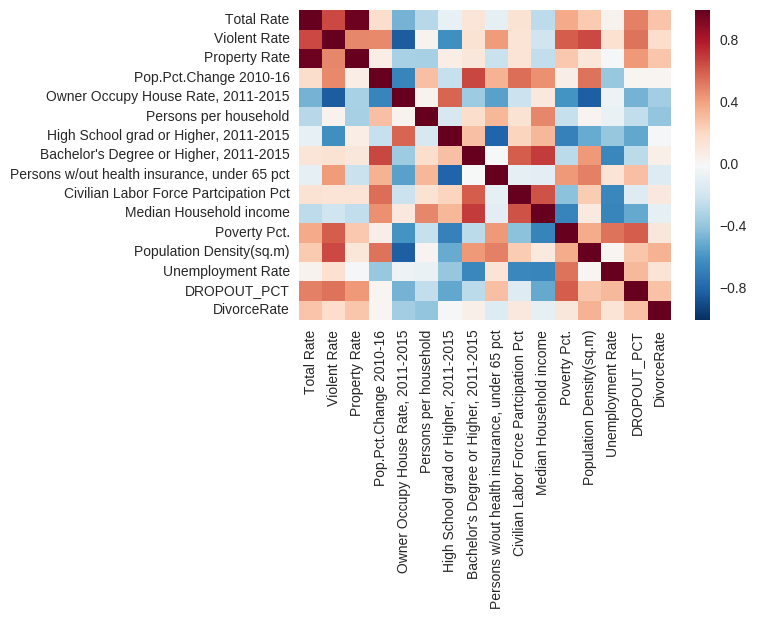

In [19]:
# Create a heatmap of correlation matrix
sns.heatmap(df.corr())

Looking at the heatmap, we notice a few variables that have modest correlation coefficients with Total Rate. Some of these are the percent of highschool dropouts, percent of population living in poverty, and the rate of those who live in the house they own. 

<h3 style='color: gray'>2b. Finding the right variables</h3>
***

In [20]:
# Reduce the variables for our regression to those with a p-value of < 0.05 when computing their correlation
# coefficient.

sig_attributes = []
for col in df.columns[4:]:
    cor, p_value = pearsonr(df['Total Rate'], df[col])
    if p_value <= 0.05:
        sig_attributes.append(col)
        print('{0}\nCorrelation Coefficient: {1}, P-value: {2}\n'.format(col,cor,p_value))


Owner Occupy House Rate, 2011-2015
Correlation Coefficient: -0.47654216156437834, P-value: 9.025936684477753e-05

Persons per household
Correlation Coefficient: -0.2753983200351262, P-value: 0.030277511511942506

Median Household income
Correlation Coefficient: -0.2602265497748552, P-value: 0.041085640422094595

Poverty Pct.
Correlation Coefficient: 0.37898023469662123, P-value: 0.002385125635546153

Population Density(sq.m)
Correlation Coefficient: 0.26069529020082205, P-value: 0.04070948763711594

DROPOUT_PCT
Correlation Coefficient: 0.5040584438262569, P-value: 2.956737487559674e-05

DivorceRate
Correlation Coefficient: 0.28268015779945915, P-value: 0.02600442620098597



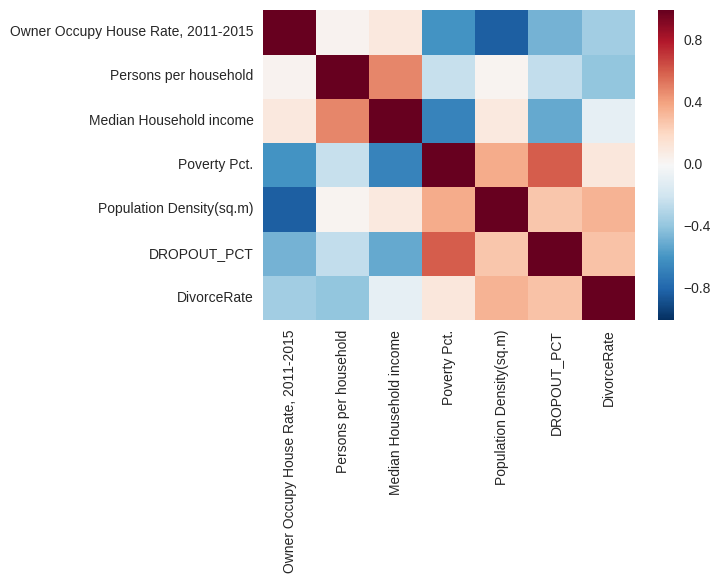

In [21]:
sns.heatmap(df[sig_attributes].corr())

After reducing our variables we can see more clearly which variables are correlated with each other. Four in particular stick out to me:

1. Owner Occupy House Rate, 2011-2015 with Poverty Pct.: -0.599762
2. Median Household Income with Poverty Pct:             -0.665606
3. DROPOUT_PCT wiht Poverty Pct:                          0.608678
4. Median Household Income with DROPOUT_PCT:             -0.509701

We're likely going to have to drop even more variables after our regression because many of these variables appear
collinear as we would expect. For example, we probably aren't surprised that on average counties with a higher percent of those in the population living under the poverty line have higher high school dropout rates. The reasons for this may be that school funding for such areas may be minimal, students may need to help their parents out with living expenses, etc.

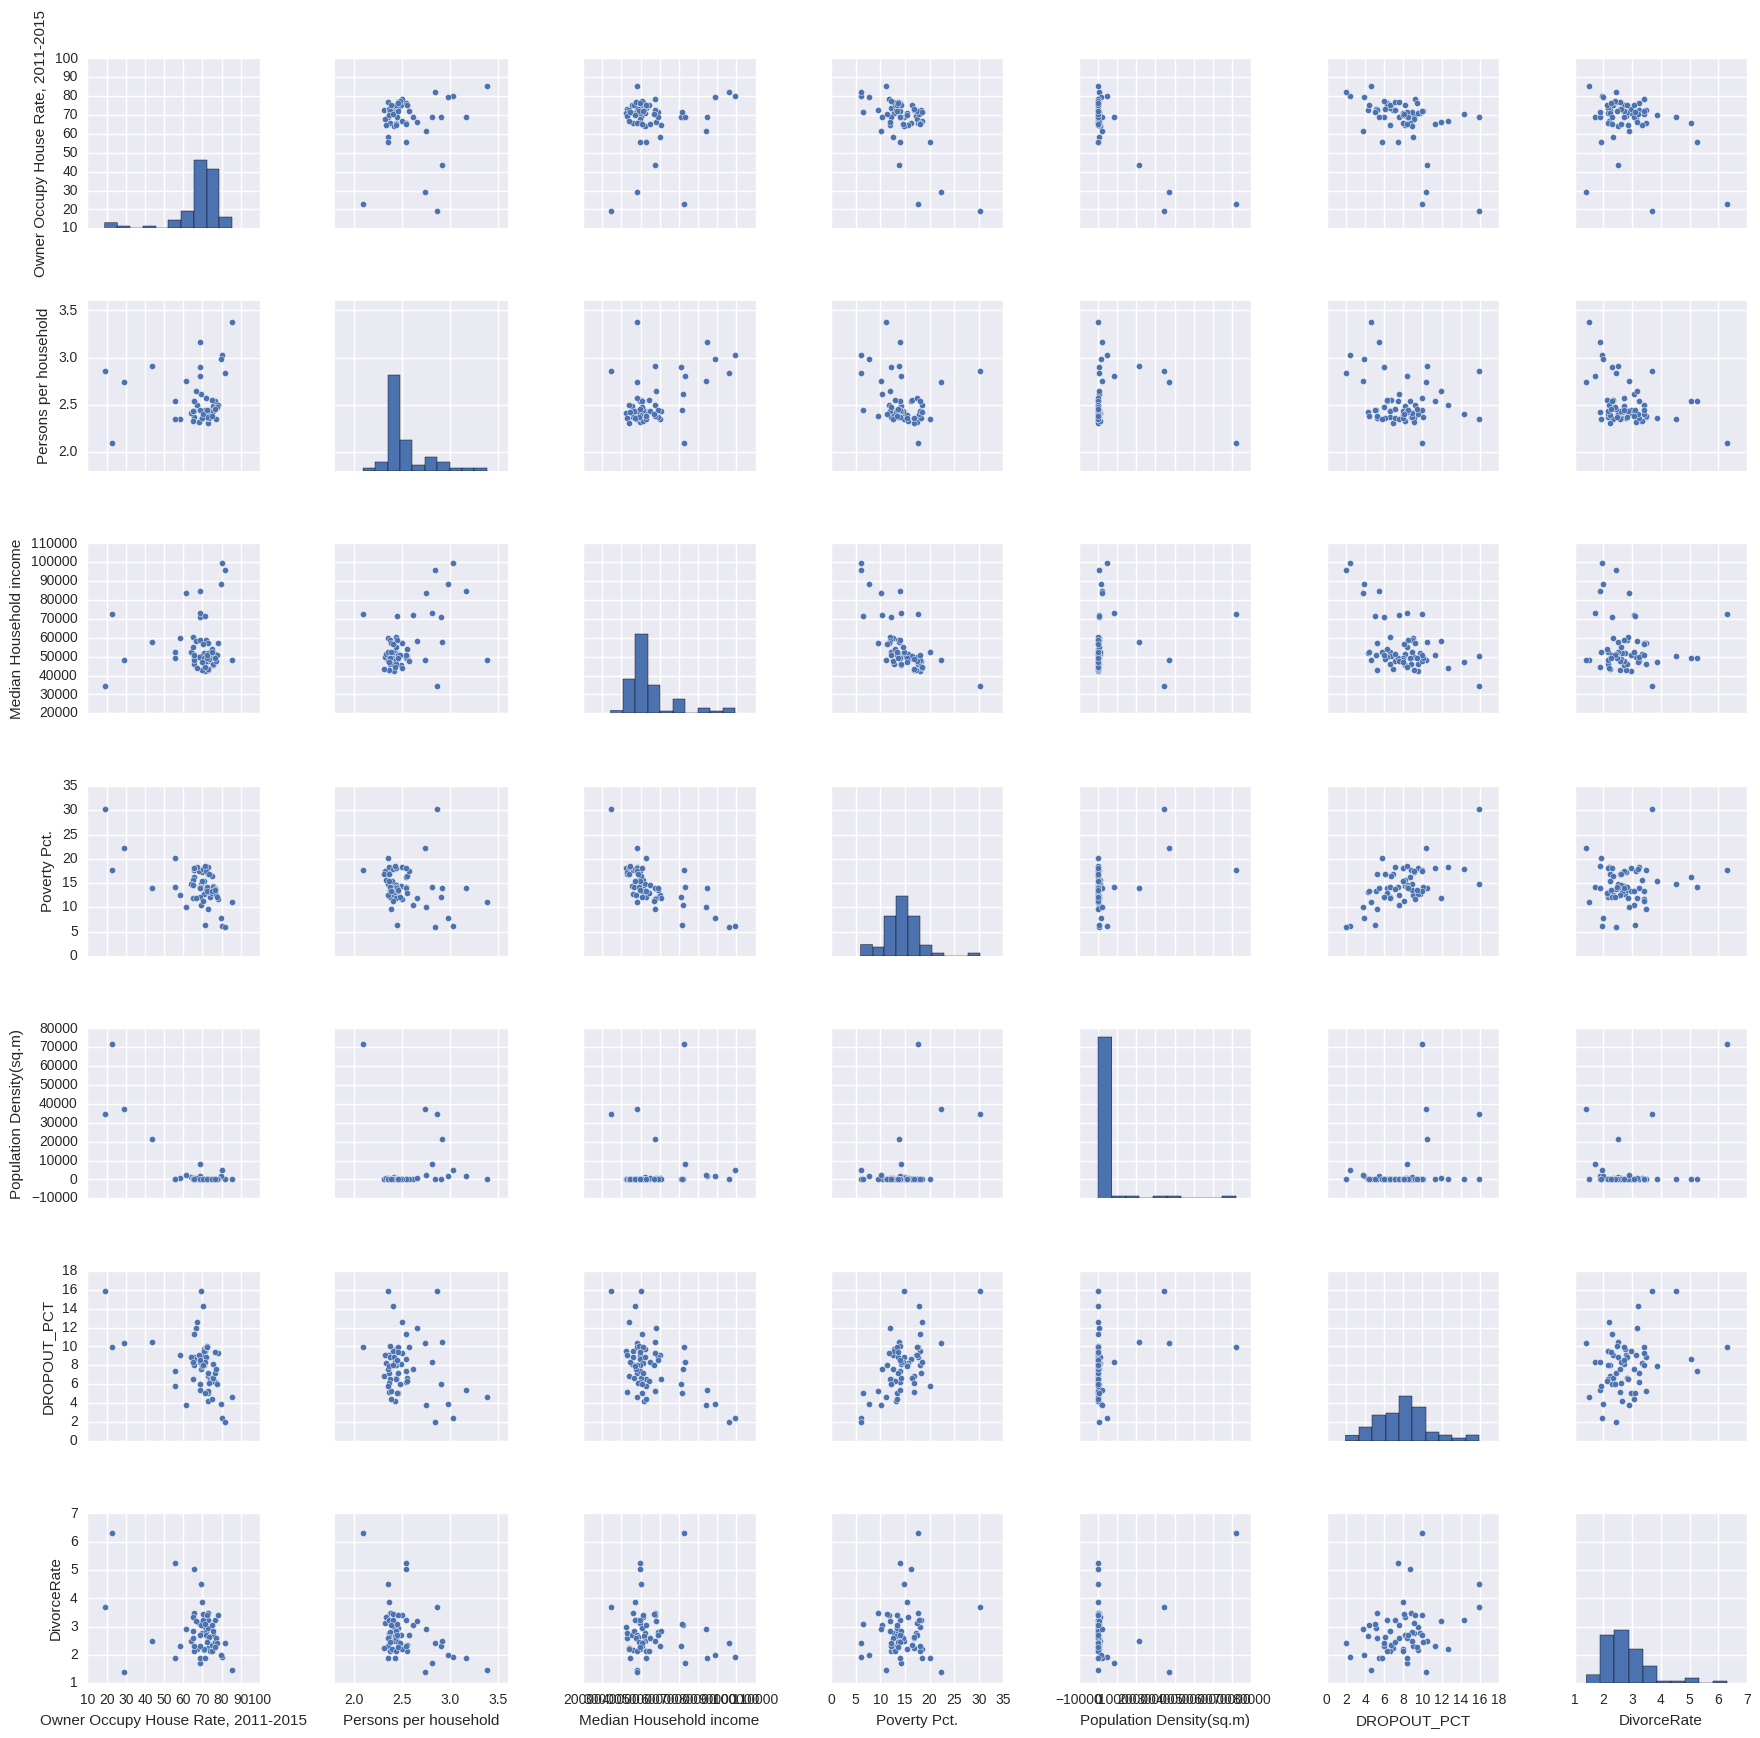

In [22]:
sns.pairplot(df[sig_attributes])

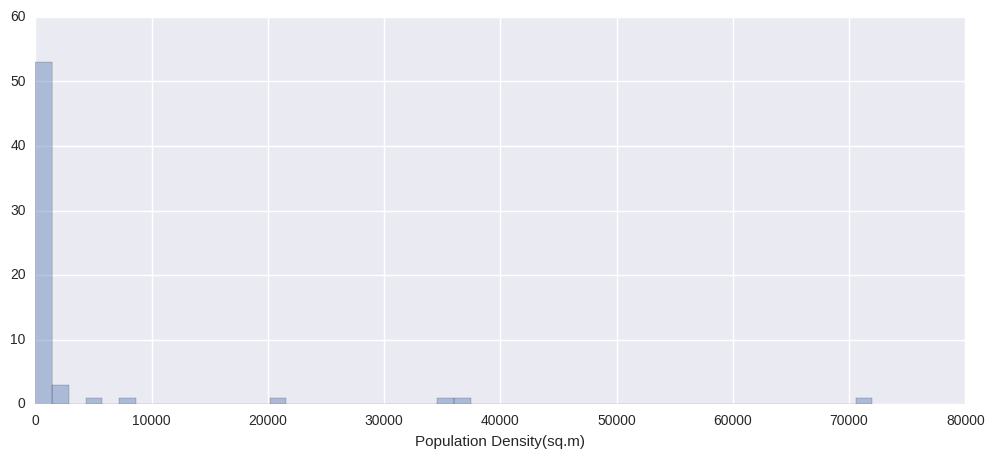

In [23]:
fig , ax1 = plt.subplots(1,1,figsize=(12,5))

sns.distplot(df['Population Density(sq.m)'],ax=ax1,kde=False)

Because there are so many outlier values in the Population Density variable we will not include it in our regression.

<h3 style='color: gray'>2c. OLS Regression</h3>
***

In [24]:
#Let's create a dataset of the with only those variables we think have a relationship with the Total crime Rate
df_final = df[['Total Rate', 'Persons per household', 'Median Household income', 'Poverty Pct.', 'DROPOUT_PCT',
         'Owner Occupy House Rate, 2011-2015', 'DivorceRate']]

df_final.columns = ['C_rate', 'PPH', 'MedianIncome', 'PctPoverty', 'PctDropout', 'HouseOwnerRate', 'DivorceRate']

In [25]:
# First we're going to run an OLS regression on all the selected variables.
est1 = ols(formula='C_rate ~ PPH + MedianIncome + PctPoverty + PctDropout + HouseOwnerRate + DivorceRate',
           data=df_final).fit()

print(est1.summary())

                            OLS Regression Results                            
Dep. Variable:                 C_rate   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     5.301
Date:                Sat, 16 Sep 2017   Prob (F-statistic):           0.000226
Time:                        13:58:28   Log-Likelihood:                -41.006
No. Observations:                  62   AIC:                             96.01
Df Residuals:                      55   BIC:                             110.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.1641      1.647      2.

If we look at the p-values for our variables only two are below our 0.05 designation, PctDropout and HouseOwnerRate. 

In [26]:
est2 = ols(formula='C_rate ~ HouseOwnerRate + PctDropout',data=df_final).fit()

print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                 C_rate   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     14.38
Date:                Sat, 16 Sep 2017   Prob (F-statistic):           8.19e-06
Time:                        13:58:28   Log-Likelihood:                -42.844
No. Observations:                  62   AIC:                             91.69
Df Residuals:                      59   BIC:                             98.07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.1303      0.537      3.

<h2>Conclusion</h2>
***

<h3 style='color: gray'>3a. Results</h3>
***

After completing our analysis we found that the percent of high school students that drop out of highschool and the rate of Owner Occupied Housing have a strong relationship with the Total Crime Rate. The results for our final regression tell us quite a few things. An increase of the Owner Occupied Housing Rate by 1% will result in a decrease in the Total Crime Rate on average by about 0.0151% per thousand people. An increase of the percent of high school dropouts by one percent will result in an increase in the Total Crime Rate by 0.0669% per thousand people.

<h3 style='color: gray'>3b. Limitations</h3>
***

There are quite a number of limitations in this analysis but I'll briefly mention a few of them. 

A. Limitations of the Analysis itself:

1. We only have data for the counties of New York City in the year of 2016. Ideally, we would want to have data for multiple years as well as for different states. Many of the variables did have data going years back, however, some of them didn't.
2. There are probably other variables I could have found and included in this analysis but I choose to only use a limited amount because they were only 62 points of data making too many variables potentially problematic.

B. Limitations of trying to understand what affects crime using a data driven approach:
(Note that I'm not an expert on the topic)

1. Many of the variables that affect crime aren't easily subjected to this form of analysis. Some of these include citizens attitudes towards crime and policies of other components of the criminal justice system.